# Library Import


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data import

In [ ]:
uploaded = files.upload()

Saving user-topic-qa-data(1).xlsx to user-topic-qa-data(1).xlsx


In [35]:
raw_data = pd.read_excel('user-topic-qa-data(1).xlsx')
data = raw_data.copy()

In [36]:
data.head()

,modified_on,question,correct,user,time_spend,answers,text,options,correct_responses,difficulty_level,exam,level,group_concat(distinct (qc.concept)),group_concat(distinct (ecm.topic))
0,2020-10-22 05:33:41.100,1763,NaN,28.0,58,[],"<p>Find the average of 1.1, 0.01, 0.101, 0.001...","[""<p>2.664</p>"",""<p>1.2664</p>"",""<p>0.2664</p>...","[""2""]",1.0,RRB_NTPC,1.55,AVERAGES,AVERAGES
1,2020-10-22 05:35:43.241,1765,0,28.0,156,"[""2""]","<p>The average of 1, 3, 5, 7, 9, 11 ……upto 25 ...","[""<p>125</p>"",""<p>15</p>"",""<p>625</p>"",""<p>25<...","[""3""]",1.5,RRB_NTPC,1.55,AVERAGES,AVERAGES
2,2020-10-22 05:35:50.140,1769,1,28.0,51,"[""0""]",<p>The average of cube of the first 10 natural...,"[""<p>100</p>"",""<p>304.5</p>"",""<p>302.5</p>"",""<...","[""1""]",2.5,RRB_NTPC,1.55,AVERAGES,AVERAGES
3,2020-10-22 05:34:34.614,1760,0,28.0,95,"[""1""]",<p>The average marks obtained by 8 students we...,"[""<p>58</p>"",""<p>59</p>"",""<p>&nbsp;60</p>"",""<p...","[""2""]",1.5,RRB_NTPC,1.55,AVERAGES,AVERAGES
4,2020-10-22 05:31:23.420,1764,0,28.0,8,"[""1""]","<p>Out of 20 boys, 6 boys are each of 1m 15 cm...","[""<p>1m 12.1cm</p>"",""<p>1m 21.1cm</p>"",""<p>1m ...","[""0""]",1.5,RRB_NTPC,1.55,AVERAGES,AVERAGES


# Data cleaning and Encoding

In [37]:
# to combine the responses splitted into 2 rows
for i in range(len(data)):
  if type(data['question'][i])!=int:
    data['options'][i-1]=data['question'][i]
    data['correct_responses'][i-1]=data['correct'][i]
    data['difficulty_level'][i-1]=data['user'][i]
    data['exam'][i-1]=data['time_spend'][i]
    data['level'][i-1]=data['answers'][i]
    data['group_concat(distinct (qc.concept))'][i-1]=data['text'][i]
    data['group_concat(distinct (ecm.topic))'][i-1]=data['options'][i]
    data.drop(labels=i,axis=0,inplace=True)
data.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

In [38]:
def data_encoding(data):
  data['correct'].fillna(0, inplace=True)
  exam_names = ['RRB_NTPC', 'SSC_CHSL', 'SSC_CGL']    # list of exam names
  data = data.rename(columns = {"group_concat(distinct (ecm.topic))":"topic"})
  data = data.rename(columns = {"group_concat(distinct (qc.concept))":"concept"})
  topic_names = data.topic.unique()                  # list of topic names

  # encoding names and also changing wrong from 0 to -1 then skip from null to 0 and dropping exact duplicates
  data2 = (data.replace(to_replace = {'topic' : topic_names, 'exam' : exam_names, 'correct' : 0}, 
                      value = {'topic' : range(len(topic_names)), 'exam' : range(len(exam_names)), 'correct' : -1})
          .dropna()
          .drop_duplicates())
  # incase when some of the options are nan
  data2['options'][data2.options == '[]']='nil'
  # data['options'][data.options == '[]']='nil'
  return data2
data2=data_encoding(data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
data2.head()

,modified_on,question,correct,user,time_spend,answers,text,options,correct_responses,difficulty_level,exam,level,concept,topic
0,2020-10-22 05:33:41.100,1763,-1,28.0,58,[],"<p>Find the average of 1.1, 0.01, 0.101, 0.001...","[""<p>2.664</p>"",""<p>1.2664</p>"",""<p>0.2664</p>...","[""2""]",1.0,0,1.55,AVERAGES,0
1,2020-10-22 05:35:43.241,1765,-1,28.0,156,"[""2""]","<p>The average of 1, 3, 5, 7, 9, 11 ……upto 25 ...","[""<p>125</p>"",""<p>15</p>"",""<p>625</p>"",""<p>25<...","[""3""]",1.5,0,1.55,AVERAGES,0
2,2020-10-22 05:35:50.140,1769,1,28.0,51,"[""0""]",<p>The average of cube of the first 10 natural...,"[""<p>100</p>"",""<p>304.5</p>"",""<p>302.5</p>"",""<...","[""1""]",2.5,0,1.55,AVERAGES,0
3,2020-10-22 05:34:34.614,1760,-1,28.0,95,"[""1""]",<p>The average marks obtained by 8 students we...,"[""<p>58</p>"",""<p>59</p>"",""<p>&nbsp;60</p>"",""<p...","[""2""]",1.5,0,1.55,AVERAGES,0
4,2020-10-22 05:31:23.420,1764,-1,28.0,8,"[""1""]","<p>Out of 20 boys, 6 boys are each of 1m 15 cm...","[""<p>1m 12.1cm</p>"",""<p>1m 21.1cm</p>"",""<p>1m ...","[""0""]",1.5,0,1.55,AVERAGES,0


# Text preprocessing

In [40]:
# do_preproces, for cleaning the dataset -Perform tokenisation, lemmetization, remove stopwords
# return the dataframe df which will be used in NLP implementaion 
# df includes the columns 'question','text','correct_option_text','wrong_options_text','topic'
def do_preprocess(df1):
    df1=df1.drop_duplicates('question')
    for index, row in df1.iterrows():
        filter_sentence = ''
        question = row['text']
        options=row['options']
        correctresponse=row['correct_responses']
 
        sentence = ' ' + question
 
 
        # Cleaning the sentence with regex
        sentence = sentence.replace('<p>','')#re.sub('<p>', ' ', sentence)
        sentence = sentence.replace('</p>','')#re.sub('</p>', '', sentence)
        sentence=sentence.replace("</strong>",'')
        sentence=sentence.replace("br",'')
        cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        sentence = re.sub(cleanr, '', sentence)
        sentence = re.sub('[^a-zA-Z0-9.]', ' ', sentence)
        #  Cleaning the options text with regex
        options = re.sub(r'<p>', ' ', options)
        options = re.sub(r'</p>', '#', options)
        options=options.split('#') 
        correctresponse = re.sub('[^a-zA-Z0-9.]', ' ', correctresponse)
 
        # Tokenization
        words = nltk.word_tokenize(sentence)
 
        # Stopwords removal
        stop_words=set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        
        for words in words:
            filter_sentence = filter_sentence  + ' ' + str(lemmatizer.lemmatize(words)).lower()
        print(index)
        w=''
        for i in range(len(options)):
          if i!=int(correctresponse):
            options[i] = re.sub('[^a-zA-Z0-9.,]', ' ', options[i])
            options[i]=options[i].replace("br",'')
            w=w+options[i]
        # ---------------------------------------------
        temp= re.sub("[^a-zA-Z]","",str(options))
        if temp=='nil':
          correctresponse=''
        else:
          correctresponse = re.sub('[^a-zA-Z0-9.]', ' ', options[int(correctresponse)])
          correctresponse=correctresponse.replace('nbsp','')
          # -----------------------------------------------------
        # print(w)
        df1.loc[index, 'text'] = filter_sentence
        df1.loc[index, 'correct_option_text'] = correctresponse
        df1.loc[index, 'wrong_options_text'] =w
    df1 = df1[['question','text','correct_option_text','wrong_options_text','difficulty_level','concept','topic']]
    return(df1)
df_final=do_preprocess(data2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Streaming output truncated to the last 5000 lines.
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1439
1443
1444
1445
1447
1448
1505
1506
1507
1508
1509
1510
1511
1512
1513
1516
1518
1519
1520
1521
1522
1523
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1668
1669
1670
1671
1672
1673
1674
1675
1679
1680
1681
1682
1683
1684
1685
1686
1689
1697
1698
1699
1707
1709
1710
1711
1714
1715
1716
1717
1719
1720
1722
1723
1725
1726
1846
1847
1930
1931
1932
1933
1934
1935
1936
1937
2010
2011
2012
2015
2017
2018
2019
2067
2069
2070
2071
2073
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088

In [41]:
df_final.head(10)

,question,text,correct_option_text,wrong_options_text,difficulty_level,concept,topic
0,1763,find average 1.1 0.01 0.101 0.001 0.11,0.2664,"2.664 , 1.2664 , 0.2554",1.0,AVERAGES,0
1,1765,the average 1 3 5 7 9 11 upto 25 term,25,"125 , 15 , 625",1.5,AVERAGES,0
2,1769,the average cube first 10 natural number,304.5,"100 , 302.5 , 380",2.5,AVERAGES,0
3,1760,the average mark obtained 8 student 51 9 stud...,60,"58 , 59 , 61",1.5,AVERAGES,0
4,1764,out 20 boy 6 boy 1m 15 cm height 8 1m 10 cm r...,1m 12.1cm,", 1m 21.1cm , 1m 21cm nbsp , 1m 12cm",1.5,AVERAGES,0
5,1916,the average weight 12 crewman boat increased ...,59,"50 , 53 , 56",2.5,AVERAGES,0
6,1912,the average 9 number 30 . the average first 5...,40,"30 , 50 , 45",2.0,AVERAGES,0
7,1911,eight consecutive number given average two nu...,48,"36 , 46 , 52",2.0,AVERAGES,0
8,1770,the average square first 10 natural number,38.5,", 37.5 , 39.5 , 38",2.0,AVERAGES,0
9,1918,a cricketer whose bowling average 24.85 run p...,80,"90 , 70 , 75",3.0,AVERAGES,0


# Girth implementation
To estimate difficulty and descrimination parameter of the question having enough responses

In [42]:
# itemmatrix function return the matrix contains qns havingng enough number of 
# responses for pararmeter estimation by using girth
# min_response- minimum responses considered
# ind-indexes of qns Or Question ids having enough responses
# responsematrix-matrix containing arrays of responses in format [[][][]]
# response_rate-response rate of question at index ind


def itemmatrix(df,min_response):
    finaldata4=df[['user','question','correct']].sort_values('question')
    questionind=finaldata4['question'].unique()
    s=[]     #array of responses of qns having 50+ responses 
    ind=[]   #Question ids of these particular qns
    # response_rate=[]
    for i in questionind:
      arr=[]
      item=finaldata4[['correct']][finaldata4['question']==i]
      k=0
      if len(item)>min_response:
        ind.append(i)
        for j in item["correct"]:
          if k<min_response:
            if j==1:
              arr.append(True)
              k=k+1
            if j==-1:
              arr.append(False)
              k=k+1
        s=s+[arr]
    print('Total number of eligible question',len(s))
    if len(s)>1:
      responsematrix=np.stack(s, axis=0)
      return ind,responsematrix
    else:
      return -1,-1
# ind,item_mat=itemmatrix(data2)

In [43]:
# from girth import twopl_mml
# def itemmatrix_topicwise(df):
#   topics=df['topic'].unique()
#   ind1=[]
#   diff_girth=[]
#   desc_girth=[]
#   for t in topics:
#     df_topic=df[df['topic']==t]
#     print(t)
#     ind,temp=itemmatrix(df_topic)
#     if ind==-1:
#       pass
#     else:
#       est_params_twopl=twopl_mml(temp,options=None)
#       ind1.extend(ind)
#       diff_girth.extend(est_params_twopl['Difficulty'])
#       desc_girth.extend(est_params_twopl['Discrimination'])
#   return ind1,diff_girth,desc_girth
# index,Difficulty_girth, Discrimination_girth=itemmatrix_topicwise(data2)
# print(len(index))
# print(len(Difficulty_girth))
# print(len(Discrimination_girth))

In [44]:
ind,item_mat=itemmatrix(data2,100)

Total number of eligible question 140


In [45]:
pip install girth

  Created wheel for girth: filename=girth-0.3.7-py3-none-any.whl size=42736 sha256=293affee115b29440cf965430797d068952ef396e3f6bf7cbb7b2f21f596b353
  Stored in directory: /root/.cache/pip/wheels/42/5c/1e/aa19a3fb0157598c9b3bd2d0ebc46d85d57f100629ab0dc563
Successfully built girth


In [46]:
from girth import twopl_mml
est_params=twopl_mml(item_mat, options=None)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [47]:
# from girth import twopl_mml
# est_params_twopl=twopl_mml(ss,options=None)
# from girth import onepl_mml
# est_params_onepl=onepl_mml(ss,options=None)


# NLP implementation for parameter estimation

In [48]:
finaldata=df_final[df_final['question'].isin(ind)]
FinalData=finaldata.sort_values('question')
FinalData['complete_text']=data['text'][data['question'].isin(ind)]
# df = pddf['column_name'].
FinalData['diificulty_girth']=pd.DataFrame(est_params['Difficulty']).values
FinalData['descrimination_girth']=pd.DataFrame(est_params['Discrimination']).values
FinalData.head()

,question,text,correct_option_text,wrong_options_text,difficulty_level,concept,topic,complete_text,diificulty_girth,descrimination_girth
7560,143,which largest fresh water lake asia,Wular Lake,"Dal Lake , Chilka Lake , Sambhar Lake",2.0,INDIAN_PHYSICAL_GEOGRAPHY,20,<p>Which is largest fresh water lake in Asia?</p>,-1.987800,0.250005
15425,157,narmada river originates amarkantak range state,Madhya Pradesh,"Maharashtra , Chattisgarh , Jharkhand",1.5,INDIAN_PHYSICAL_GEOGRAPHY,20,<p>Narmada river originates from Amarkantak ra...,-0.426446,1.462769
1352,263,which one following prone earth quake,Young folded mountains,"Coastal plains , Plateaus , Old Shields",2.5,ENVIRONMENTAL_AND_ECOLOGY,20,<p>Which one of the following is most prone to...,3.751227,0.283910
15423,330,which among following area receives highest a...,Tropical evergreen forests,", Tropical deciduous forests , Tropical dry...",1.5,INDIAN_PHYSICAL_GEOGRAPHY,20,<p>Which among the following areas receives th...,-4.035318,0.250005
1355,368,which river india flow highest number state,Godavari,", Ganga , Brahmaputra , Mahanadi",2.5,INDIAN_PHYSICAL_GEOGRAPHY,20,<p>Which river in india flows through the high...,3.022383,0.530332


In [49]:
testdata=df_final[df_final['question'].isin(ind)==False]
testdata.head()

,question,text,correct_option_text,wrong_options_text,difficulty_level,concept,topic
0,1763,find average 1.1 0.01 0.101 0.001 0.11,0.2664,"2.664 , 1.2664 , 0.2554",1.0,AVERAGES,0
1,1765,the average 1 3 5 7 9 11 upto 25 term,25,"125 , 15 , 625",1.5,AVERAGES,0
2,1769,the average cube first 10 natural number,304.5,"100 , 302.5 , 380",2.5,AVERAGES,0
3,1760,the average mark obtained 8 student 51 9 stud...,60,"58 , 59 , 61",1.5,AVERAGES,0
4,1764,out 20 boy 6 boy 1m 15 cm height 8 1m 10 cm r...,1m 12.1cm,", 1m 21.1cm , 1m 21cm nbsp , 1m 12cm",1.5,AVERAGES,0


In [50]:
from sklearn.model_selection import train_test_split
text=FinalData['text'].astype(str)+' '+FinalData['concept'].astype(str)
train_text,val_text,train_labels,val_labels=train_test_split(text,FinalData[['diificulty_girth','descrimination_girth'
]],test_size=0.1)
print(train_text.shape)
print(val_text.shape)
print(train_labels.shape)
print(val_labels.shape)

(126,)
(14,)
(126, 2)
(14, 2)


In [51]:
test_text=testdata['text'].astype(str)+' '+testdata['concept'].astype(str)
test_text.shape

(5587,)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1),use_idf=True,max_features=300)
mat=tfidf.fit_transform(train_text).toarray()
train_df=pd.DataFrame(mat,columns=tfidf.get_feature_names())
val_df=pd.DataFrame(tfidf.transform(val_text).toarray(),columns=tfidf.get_feature_names())
test_df=pd.DataFrame(tfidf.transform(test_text).toarray(),columns=tfidf.get_feature_names())
train_df.head()

,032,air,among,analogy,appropriate,area,army,asian,association,atmosphere,average,award,awarded,becomes,biology,blank,building,called,changing,chemistry,choice,city,civilization,coded,coding_decoding,colleges,company,complete,computers,conjunction,constitution,correct,country,current,dedicated,di_tabular,dinner,earth,earth_and_its_atmosphere,expenditure,...,unique,unit,united,universal,universe_and_solar_system,upanishads,usa,used,useful,using,vaccine,valley,vector,veda,vedic_age__ancient_india,venus,vice,victoria,vitamin,volcanic,volume,water,wave,wechat,well,what,whats,when,which,who,win,window,wire,word,world,world_geography,would,written,www,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635896,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455136,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.373874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.406144,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.494023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394532,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.352102,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
from sklearn.ensemble import RandomForestRegressor

model1=RandomForestRegressor()
model2=RandomForestRegressor()

model1.fit(train_df,train_labels['descrimination_girth'])
model2.fit(train_df,train_labels['diificulty_girth'])

val_pred_dis=model1.predict(val_df)
val_pred_diff=model2.predict(val_df)

from sklearn.metrics import mean_squared_error
print('train error for discrimination:',mean_squared_error(train_labels['descrimination_girth'],model1.predict(train_df)))
print('train error for difficulty:',mean_squared_error(train_labels['diificulty_girth'],model2.predict(train_df)))

print('val error for discrimination:',mean_squared_error(val_labels['descrimination_girth'],val_pred_dis))
print('val error for difficulty:',mean_squared_error(val_labels['diificulty_girth'],val_pred_diff))

test_pred_dis=model1.predict(test_df)
test_pred_diff=model2.predict(test_df)

train error for discrimination: 0.011425315769084742
train error for difficulty: 1.3886016493869489
val error for discrimination: 0.05600473124093979
val error for difficulty: 9.679515064201054


In [54]:
testdata['diificulty_girth']=test_pred_diff
testdata['descrimination_girth']=test_pred_dis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
params_df=pd.concat([FinalData[['question','difficulty_level','diificulty_girth','descrimination_girth']],testdata[['question','difficulty_level','diificulty_girth','descrimination_girth']]]).reset_index()

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler((1,5))
params_df[['diificulty_girth']]=scaler.fit_transform(params_df[['diificulty_girth']])


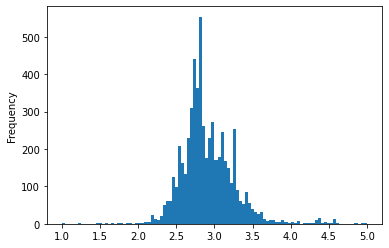

In [57]:
params_df['diificulty_girth'].plot(kind='hist',bins=100)

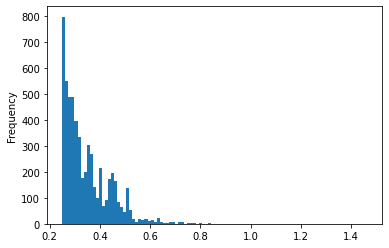

In [58]:
params_df['descrimination_girth'].plot(kind='hist',bins=100)

In [59]:
params_df

,index,question,difficulty_level,diificulty_girth,descrimination_girth
0,7560,143,2.0,2.337395,0.250005
1,15425,157,1.5,2.857850,1.462769
2,1352,263,2.5,4.250417,0.283910
3,15423,330,1.5,1.654885,0.250005
4,1355,368,2.5,4.007468,0.530332
...,...,...,...,...,...
5722,95080,33413,4.0,2.889984,0.474110
5723,95081,33412,3.5,2.728978,0.281132
5724,95082,33566,3.5,2.721325,0.265430
5725,95083,33387,3.0,2.803002,0.250024


In [60]:
params_df[['question','difficulty_level','diificulty_girth','descrimination_girth']].to_csv('est_params.csv')